In [2]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline
import os
import glob
from copy import deepcopy
import scipy.io as sio 
import sys
import dlib


In [3]:
predictor_path = "shape_predictor_68_face_landmarks.dat/data"
# faces_folder_path = "./Eye_chimeraToPublish/Centre"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

def get_landmarks(im):
    """Single face landmark detector. return an nparray."""
    rects = detector(im, 1)
    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

In [4]:
# # Define the face and eye classifier
# face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
# eye_cascade = cv2.CascadeClassifier('./haarcascade_eye.xml')
# img = mpimg.imread('./data/Eye_chimeraToPublish/0/eyes003019.jpg')
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(gray, cmap='gray')
# gray = gray.reshape((480,640,1))

In [5]:
# faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# for (x,y,w,h) in faces:
#     cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
#     roi_gray = gray[y:y+h, x:x+w]
#     roi_color = img[y:y+h, x:x+w]
#     eyes = eye_cascade.detectMultiScale(roi_gray)
#     for (ex,ey,ew,eh) in eyes:
#         cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
# # plt.plot(121,53,'o')
# plt.imshow(img)
# # cv2.imshow('img',gray)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# print(eyes)

In [6]:
# load in eye_cinmera data, return image/label/matrix.
def load_eye_cinmera():
    X = []
    y = []
    Mat = []
    for i in range(7):
        faces_folder_path = "./data/Eye_chimeraToPublish/" + str(i)
        for f in glob.glob(os.path.join(faces_folder_path, "*.jpg")):
            f_name = os.path.basename(f)
            f_basename = f_name.split(".", 1)[0]
            # matrix file has the same name with the image file
            mat_name = f_basename + ".mat"
            mat_path = os.path.join(faces_folder_path, mat_name)
            img = io.imread(f)
            X.append(img)
            y.append(i)
            Mat.append(sio.loadmat(mat_path)['eyePoints'])
    return X, y, Mat
X, y, Mat = load_eye_cinmera()

(1135, 30, 50, 3)


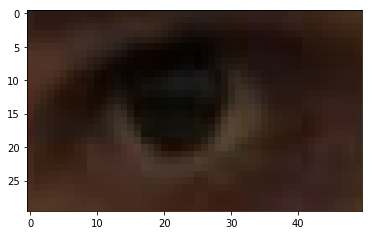

In [7]:
def extract_eye_by_mat(X, Mat, pad_scale=0.4, resize_width=50, resize_height=30):
    """given image and eye location datasets, return two eye images dataset."""
    X_left = []
    X_right = []
    for (img, mat) in zip(X, Mat):
        # the four egdes of left and right eyes
        left_left = mat[0][0]
        left_right = mat[1][0]
        left_top = mat[2][1]
        left_bottom = mat[3][1]
        right_left = mat[5][0]
        right_right = mat[6][0]
        right_top = mat[7][1]
        right_bottom = mat[8][1]
        # cut eyes images from the original one
        
        left_pad_width = int((left_right - left_left) * pad_scale)
        left_pad_height = int((left_bottom - left_top) * pad_scale)
        
        right_pad_width = int((right_right - right_left) * pad_scale)
        right_pad_height = int((right_bottom - right_top) * pad_scale)
        
        left_eye = img[left_top-left_pad_height : left_bottom+left_pad_height, left_left-left_pad_width : left_right+left_pad_width, :]
        right_eye = img[right_top-right_pad_height : right_bottom+right_pad_height, right_left-right_pad_width : right_right+right_pad_width, :]
        
        # reshape eye images to 50x42
        X_left.append(cv2.resize(left_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC))
        X_right.append(cv2.resize(right_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC))
        
    return np.array(X_left), np.array(X_right)
X_left, X_right = extract_eye_by_mat(X, Mat)
plt.imshow(X_left[1])
print(X_left.shape)


In [8]:
X_combine = np.concatenate((X_left, X_right), axis=2)
X_combine.shape

(1135, 30, 100, 3)

In [9]:
def extract_eyes_by_dlib(img, pad_scale=0.4, resize_width=50, resize_height=30, combine=False):
    # get facial landmark matrix by dlib
    mat = get_landmarks(img)
    
    left_left = mat[36,0]
    left_right = mat[39,0]
    left_top = min(mat[37,1], mat[38,1])
    left_bottom = max(mat[40,1], mat[41,1])
    right_left = mat[42,0]
    right_right = mat[45,0]
    right_top = min(mat[43,1], mat[44,1])
    right_bottom = max(mat[46,1], mat[47,1])
    # left pad
    left_pad_width = int((left_right - left_left) * pad_scale)
    left_pad_height = int((left_bottom - left_top) * pad_scale)
    # right pad
    right_pad_width = int((right_right - right_left) * pad_scale)
    right_pad_height = int((right_bottom - right_top) * pad_scale)
    # left and right eye plus pads
    left_eye = img[left_top-left_pad_height : left_bottom+left_pad_height, left_left-left_pad_width : left_right+left_pad_width]
    right_eye = img[right_top-right_pad_height : right_bottom+right_pad_height, right_left-right_pad_width : right_right+right_pad_width]
    # resize
    left_eye = cv2.resize(left_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC)
    right_eye = cv2.resize(right_eye,(resize_width, resize_height),interpolation=cv2.INTER_CUBIC)
    if combine:
        return np.concatenate((left_eye, right_eye), axis=1)    
    return left_eye, right_eye
    

# example_img = io.imread("./data/columbia_gaze_data_set/Columbia Gaze Data Set/0001/0001_2m_0P_0V_0H.jpg")
# example_left, example_right = extract_eyes_by_dlib(example_img)
# example_combine = extract_eyes_by_dlib(example_img, combine=True)

# plt.imshow(example_combine)
# print(example_combine.shape)

In [10]:
def hist_equ(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    equ = cv2.equalizeHist(gray_img)
    return equ.reshape(equ.shape[0], equ.shape[1], 1)

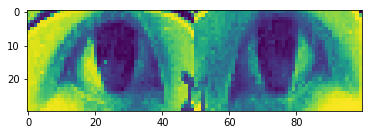

In [13]:
plt.imshow(hist_equ(example_combine).squeeze())

In [11]:
def comb_hist_eye_cinmera(X_left, X_right):
    X_combine = np.concatenate((X_left, X_right), axis=2)
    X_combine_equ = np.empty(30*100*1135).reshape(1135, 30, 100, 1)
    for i in range(1135):
        equ = hist_equ(X_combine[i])
        X_combine_equ[i] = equ
    return X_combine_equ

(30, 100, 1)


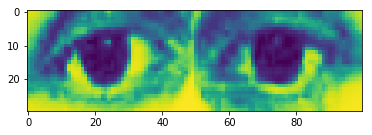

In [12]:
X_combine_equ = comb_hist_eye_cinmera(X_left, X_right)
plt.imshow(X_combine_equ[10].squeeze())
print(X_combine_equ[0].shape)

In [13]:
def pre_process(img, img_width=640, img_height=480, out_width=50, out_height=30):
    """Input a raw image, process to a certain format to throw into CNN."""
    """Return combined, equalized eyes with size (30, 100, 1)."""
    # gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # if the input image is not (640x480), resize to this shape.
    if gray.shape != (img_height, img_width):
        gray = cv2.resize(gray,(img_width, img_height),interpolation=cv2.INTER_CUBIC)
    # Do a Histogram Equalization 
    equ = cv2.equalizeHist(gray)
    # extract eyes by dlib and concatenate left and right eye images.
    eyes_img = extract_eyes_by_dlib(equ, pad_scale=0.4, resize_width=out_width, resize_height=out_height, combine=True)
    print(eyes_img.shape)
    # eyes_img.shape = (30, 100, 1)
    return eyes_img.reshape(out_height, out_width*2, 1)
    

(1135, 30, 100, 1)
X_train shape:  (908, 30, 100, 1)
X_valid shape:  (227, 30, 100, 1)
y_train shape:  908
y_valid shape:  227
(908, 30, 100, 1)


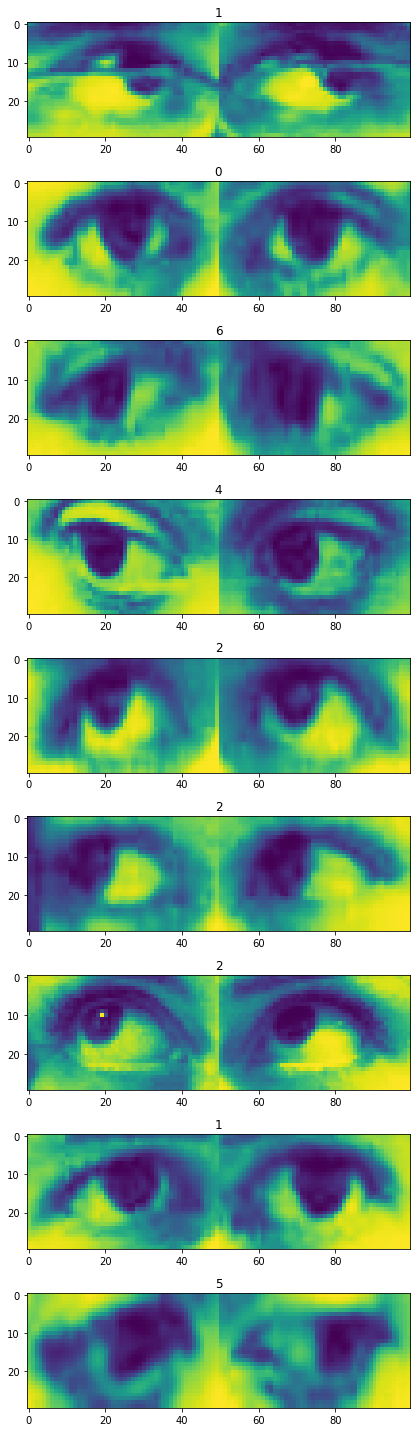

In [14]:
# change this input to X_combine, X_left or X_right
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
def shuffle_and_split(X, y, valid_ratio=0.2):
    # Shuffle X and y
    X, y = shuffle(X, y)
    print(X.shape)
    # Split out test set
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=valid_ratio, random_state=42)
    print("X_train shape: ", X_train.shape)
    print("X_valid shape: ", X_valid.shape)
    print("y_train shape: ", len(y_train))
    print("y_valid shape: ", len(y_valid))
    # chang data type to floate32
    # X_train = X_train.astype('float32')
    # X_test = X_test.astype('float32')
    plt.figure(2, figsize=(16,20))
    for i in range(0, 9):
        plt.subplot(9, 1, i+1)
        plt.tight_layout()
        plt.imshow(X[i].squeeze())
        plt.title(str(y[i]))

    print(X_train.shape)
    return X_train, X_valid, y_train, y_valid

X_train, X_valid, y_train, y_valid = shuffle_and_split(X_combine_equ, y)

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
# from keras.callbacks import 


num_classes = 7
input_shape = (30, 100, 1)

model = Sequential()

model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=input_shape))

# Conv1
model.add(Conv2D(6, kernel_size=(5, 5),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Conv2
model.add(Conv2D(16, (5, 5), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Dropout(0.25))
# FC1
model.add(Flatten())
model.add(Dense(120, activation='relu'))
# model.add(Dropout(0.5))
# FC2
model.add(Dense(84, activation='relu'))
# FC#
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.summary()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

/home/nqiao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 30, 100, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 96, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 48, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 44, 16)         2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 22, 16)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               169080    
__________

In [ ]:

BATCH_SIZE = 128
EPOCHS = 100
model.fit(x=X_train, y=y_train, 
          batch_size=BATCH_SIZE, 
          epochs=EPOCHS, verbose=1, 
          validation_data=(X_valid, y_valid), 
          shuffle=True)

In [15]:
import tensorflow as tf
BATCH_SIZE = 128

/home/nqiao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [16]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1408, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 7), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(7))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [17]:
# Set placeholders for inputs
# Change this RGB to GRAY if gray scale is applied.
x_holder = tf.placeholder(tf.float32, (None, 30, 100, 1))
y_holder = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y_holder, 7)

In [18]:
rate = 0.001

# logits: the score of a data point
logits = LeNet(x_holder)
# the distance between score and the ground truth
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# our goal is to min this average
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [19]:
"""Model Evaluation"""
# tf.argmax: Returns the index with the largest value across axis of a tensor.
# this step is to compare the prediction and the ground truth. E.g.: (1,1,0,1,1,0)--err:2/6
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    # tf.get_default_session(): Returns the default session for the current thread.
    # function evaluate() is called right after the training session.
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # accuracy for this particular batch
        accuracy = sess.run(accuracy_operation, feed_dict={x_holder: batch_x, y_holder: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [20]:
"""Input data"""
# Choose input dataset. 
# Options are original(X_train), normalized(X_train_nor), grayscale(X_train_gray).
X_train_input = X_train
X_valid_input = X_valid
y_train_input = y_train
y_valid_input = y_valid
# print(X_train_input.shape, y_train_input.shape)


In [21]:
"""Train model"""
# Model name: this name will be the save file name.
MODEL_NAME = "100epoch_dropout0.75"
EPOCHS = 100
saver_path = "./trained_models/model.ckpt"

# saver = tf.train.Saver()
# model_path = "./tf_models/model1.ckpt"

### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
with tf.Session() as sess:
    # create a "logs" dir which will contain information for tensorboard
#     writer = tf.summary.FileWriter("logs", sess.graph)
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # change different X_train input
        X_train_input, y_train_input = shuffle(X_train_input, y_train_input)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_input[offset:end], y_train_input[offset:end]
            sess.run(training_operation, feed_dict={x_holder: batch_x, y_holder: batch_y})
        # change different X_valid input    
        validation_accuracy = evaluate(X_valid_input, y_valid_input)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, saver_path)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.573

EPOCH 2 ...
Validation Accuracy = 0.507

EPOCH 3 ...
Validation Accuracy = 0.696

EPOCH 4 ...
Validation Accuracy = 0.727

EPOCH 5 ...
Validation Accuracy = 0.771

EPOCH 6 ...
Validation Accuracy = 0.758

EPOCH 7 ...
Validation Accuracy = 0.806

EPOCH 8 ...
Validation Accuracy = 0.802

EPOCH 9 ...
Validation Accuracy = 0.855

EPOCH 10 ...
Validation Accuracy = 0.850

EPOCH 11 ...
Validation Accuracy = 0.863

EPOCH 12 ...
Validation Accuracy = 0.863

EPOCH 13 ...
Validation Accuracy = 0.868

EPOCH 14 ...
Validation Accuracy = 0.872

EPOCH 15 ...
Validation Accuracy = 0.872

EPOCH 16 ...
Validation Accuracy = 0.907

EPOCH 17 ...
Validation Accuracy = 0.894

EPOCH 18 ...
Validation Accuracy = 0.881

EPOCH 19 ...
Validation Accuracy = 0.885

EPOCH 20 ...
Validation Accuracy = 0.890

EPOCH 21 ...
Validation Accuracy = 0.899

EPOCH 22 ...
Validation Accuracy = 0.894

EPOCH 23 ...
Validation Accuracy = 0.894

EPOCH 24 ...
Validation Accura

In [38]:
# ### Run the predictions here and use the model to output the prediction for each image.
# ### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
predict_operation = tf.argmax(logits, 1)

def predict(X_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        prediction = sess.run(predict_operation, feed_dict={x_holder: batch_x})
    return prediction

(30, 100)


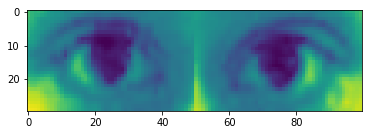

In [52]:
# Load in five German traffic sign I found from web. 
X_new = []
# for i in range(1):
example_img = io.imread("./data/Eye_chimeraToPublish/0/eyes029191.jpg")
processed_img = pre_process(example_img)
X_new.append(processed_img)
plt.imshow(processed_img.squeeze())

In [53]:
# Predict the above traffic signs.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./trained_models/'))
    prediction = predict(X_new)
    print("Predict Result : ", prediction)


INFO:tensorflow:Restoring parameters from ./trained_models/model.ckpt
Predict Result :  [0]
